# Global model-data comparison for LGM_G

In [3]:
import os
#expname = os.path.basename(os.getcwd())
expname="LGM.glomap_anomtopo_t42.20230831"

model_name1 = ""
model_name2 = "MIROC5-iso"
model_name=model_name2

import sys
sys.path.append("/data44/kanon/LGM_ensemble")
import exp_list
df_exp = exp_list.read_exp_name(model_name, model_name1=model_name1, model_name2=model_name2)
exp_label=df_exp[expname]["label"]
   

expname_ref, _, _, _, _ = df_exp.columns.tolist()
exp_label_ref, _, _, _, _ = df_exp.T["label"].tolist()

print(exp_label,":",expname)
print(exp_label_ref,":",expname_ref)

LGM_G : LGM.glomap_anomtopo_t42.20230831
PI_AMIP : PI.AMIP_t42.20230831


In [4]:
# directories (環境依存)
gcmdir="."
anldir="/data44/kanon/kino2023grl"
monitordir="/data29/kanon/monitor/miroc5-iso"
LGM_monitordir="/data29/kanon/"
# モニター図で平均する年数
intyrs=30

In [5]:
import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import gridspec
#
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
#
from netCDF4 import Dataset as NetCDFFile
from gtool3 import gtopen

from cdo import *
cdo =Cdo()
import seaborn as sns
# Original functions
from command import command as cmd
from set_colormaps import get_color_code, Color_Set
# gtool3
## Installation: https://isotope.iis.u-tokyo.ac.jp/~kanon/src/gtool4python.html
from read_gtool import read_gtool
gt = read_gtool()
gtaxdir=cmd("echo ${GTAXDIR}")

from proxy_LGM import *

In [6]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False})

In [9]:
# Read axes of t42
filename = f"model_outputs/{expname}/clm/u"
xname = gtopen(filename).vars["U"].header["AITM1"]
yname = gtopen(filename).vars["U"].header["AITM2"]
zname = gtopen(filename).vars["U"].header["AITM3"]
## Stores axes information
dlon = gtopen(f"{gtaxdir}/GTAXLOC.{xname}").vars[xname][0,0,0,:]
dlat = gtopen(f"{gtaxdir}/GTAXLOC.{yname}").vars[yname][0,0,0,:]
dlev = gtopen(f"{gtaxdir}/GTAXLOC.{zname}").vars[zname][0,0,0,:]
# number of grids
nlon =len(dlon)
nlat = len(dlat)
nlev = len(dlev)

In [10]:
csv_filename="/data44/kanon/LGM_ensemble/Antarctica_LGM_Proxies.csv"
df_reconst = pd.read_csv(csv_filename, index_col=0)

In [11]:
T2a_label = "Surface Air Temperature Anomaly"
T2a_label_s = "$\mathrm{\Delta SAT}$"
tempa_unit = "[$\mathrm{^\circ C}$]" 
prcp_d18Oa_label = " $\mathrm{\delta^{18}O_p}$ Anomaly"
prcp_d18Oa_label_s = "$\mathrm{\Delta \delta^{18}O_p}$"
prcp_d18Oa_unit = "[\u2030]" 

## Map of Annual climatology

In [12]:
inputdir=f"model_outputs/{expname}/clm/ann"
T2_input_annual_clm = inputdir+"/T2"
prcp_d18O_input_annual_clm = inputdir+"/prcp_d18O"
if os.path.exists(inputdir) == False:
    os.system(f"mkdir {inputdir}")
    
if os.path.exists(f"{T2_input_annual_clm}.nc") == False:
    os.system(f"ngtavr {inputdir}/../T2 -o {T2_input_annual_clm}")
    os.system(f"ngtcf {T2_input_annual_clm} {T2_input_annual_clm}.nc")
              
if os.path.exists(f"{prcp_d18O_input_annual_clm}.nc") == False:
    os.system(f"ngtavr {inputdir}/../../cat/1dy/prcp -o {inputdir}/prcp")
    os.system(f"ngtavr {inputdir}/../../cat/1dy/prcp01 -o {inputdir}/prcp01")
    os.system(f"isotope.exe {inputdir}/prcp {inputdir}/prcp01 {inputdir}/prcp_d18O prcp_d18O")
    os.system(f"ngtcf {prcp_d18O_input_annual_clm} {prcp_d18O_input_annual_clm}.nc" )

T2_ann = np.zeros((nlat,nlon))
T2_ann[:,:-1] = gtopen(T2_input_annual_clm).vars["T2"][0,:,:] - 273.15
T2_ann[:,-1] = T2_ann[:,0]    
prcp_d18O_ann = np.zeros((nlat,nlon))
prcp_d18O_ann[:,:-1] = gtopen(prcp_d18O_input_annual_clm).vars["prcp_d18O"][0,:,:]
prcp_d18O_ann[:,-1] = prcp_d18O_ann[:,0]     

In [13]:
inputdir=f"model_outputs/{expname_ref}/clm/ann"
T2_input_annual_clm_ref = f"{inputdir}/T2"
prcp_d18O_input_annual_clm_ref = f"{inputdir}/prcp_d18O"
if os.path.exists(inputdir) == False:
    os.system("mkdir "+inputdir)
    
if os.path.exists(f"{T2_input_annual_clm_ref}.nc") == False:
    os.system(f"ngtavr {inputdir}/../T2 -o " + T2_input_annual_clm_ref)
    os.system(f"ngtcf {T2_input_annual_clm_ref} {T2_input_annual_clm_ref}.nc")
              
if os.path.exists(f"{prcp_d18O_input_annual_clm_ref}.nc") == False:
    os.system(f"ngtavr {inputdir}/../../cat/1dy/prcp -o {inputdir}/prcp")
    os.system(f"ngtavr {inputdir}/../../cat/1dy/prcp01 -o {inputdir}/prcp01")
    os.system(f"isotope.exe {inputdir}/prcp {inputdir}/prcp01 {inputdir}/prcp_d18O prcp_d18O")
    os.system(f"ngtcf {prcp_d18O_input_annual_clm_ref} {prcp_d18O_input_annual_clm_ref}.nc" )

T2_ann_ref = np.zeros((nlat,nlon))
T2_ann_ref[:,:-1] = gtopen(T2_input_annual_clm_ref).vars["T2"][0,:,:] - 273.15
T2_ann_ref[:,-1] = T2_ann_ref[:,0]    
prcp_d18O_ann_ref = np.zeros((nlat,nlon))
prcp_d18O_ann_ref[:,:-1] = gtopen(prcp_d18O_input_annual_clm_ref).vars["prcp_d18O"][0,:,:]
prcp_d18O_ann_ref[:,-1] = prcp_d18O_ann_ref[:,0]     

In [14]:
lat_ice, lon_ice, proxy_LGM_PI_d18Op_ice,temp_PI_ice,temp_LGM_ice,d18Op_PI_ice,d18Op_LGM_ice = proxy_LGM().icecore(LGM_monitordir,f"{T2_input_annual_clm_ref}.nc",f"{T2_input_annual_clm}.nc",f"{prcp_d18O_input_annual_clm_ref}.nc",f"{prcp_d18O_input_annual_clm}.nc")

lat_speleo, lon_speleo, proxy_LGM_PI_d18Op_speleo,temp_PI_speleo,temp_LGM_speleo,d18Op_PI_speleo,d18Op_LGM_speleo = proxy_LGM().speleo(LGM_monitordir,f"{T2_input_annual_clm_ref}.nc",f"{T2_input_annual_clm}.nc",f"{prcp_d18O_input_annual_clm_ref}.nc",f"{prcp_d18O_input_annual_clm}.nc")

In [15]:
# Ice cores
dtemp_ice=temp_LGM_ice-temp_PI_ice

data_ice=pd.DataFrame({
    "longitude": lon_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)],
    "latitude": lat_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)],
    "d18O": proxy_LGM_PI_d18Op_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)],
    "md18O": d18Op_LGM_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)]-d18Op_PI_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)],
    "mtemp":dtemp_ice[~np.isnan(proxy_LGM_PI_d18Op_ice)],
})

csv_filename="/data29/kanon/monitor/data_lgmproxy/IceCores_LGM_PI.csv"
df_icecores = pd.read_csv(csv_filename, index_col=0)
ice_sites=[item for item in df_icecores.index.tolist() if "#" not in str(item) and "nan" not in str(item).lower()]
data_ice["mgrad"] = data_ice["md18O"]/data_ice["mtemp"]
data_ice.index=ice_sites
data_ice.dropna(how="any")

# Speleothems
dtemp_speleo=temp_LGM_speleo-temp_PI_speleo
data_speleo=pd.DataFrame({
    "longitude": lon_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)],
    "latitude": lat_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)],
    "d18O": proxy_LGM_PI_d18Op_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)],
    "md18O": d18Op_LGM_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)]-d18Op_PI_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)],
    "mtemp":dtemp_speleo[~np.isnan(proxy_LGM_PI_d18Op_speleo)],
})

csv_filename="/data29/kanon/monitor/data_lgmproxy/SISALv2_d18O_LGM_PI.csv"
df_speleo = pd.read_csv(csv_filename, index_col=0)
#speleo_no=[item for item in df_speleo.index.tolist() if "#" not in str(item) and "nan" not in str(item).lower()]
speleo_no=df_speleo.index.tolist()
speleo_sites=df_speleo["site_name"].tolist()
        
for i in range(len(speleo_no))[::-1]:
    if speleo_no[i][0] =="#":
        speleo_no=np.delete(speleo_no, obj=i, axis=0)
        speleo_sites=np.delete(speleo_sites, obj=i, axis=0)
data_speleo.index=speleo_sites[~np.isnan(proxy_LGM_PI_d18Op_speleo)]

data_speleo["mgrad"] = data_speleo["md18O"]/data_speleo["mtemp"]

data_speleo.dropna(how="any")
# GNIP sites

,longitude,latitude,d18O,md18O,mtemp,mgrad
Paraiso cave,-55.4500,-4.0667,2.967023,1.638261,-0.371033,-4.415409
Cold Air cave,29.1833,-24.0000,0.142552,-0.550949,-1.162811,0.473807
Jaragua cave,-56.5830,-21.0830,-1.344547,-0.218376,-1.741516,0.125394
Jerusalem west cave,35.1500,31.7833,0.789766,-0.723271,-3.375946,0.214243
Cango cave,22.2147,-33.3925,0.136681,-0.540797,-1.391785,0.388564
Liang Luar,120.4300,-8.5300,1.499255,1.075560,-1.313293,-0.818979
Liang Luar,120.4300,-8.5300,0.751553,1.075560,-1.313293,-0.818979
Bukit Assam cave,114.8000,4.0300,2.446700,2.313841,1.311310,1.764527
Sofular cave,31.9333,41.4167,-5.287771,-0.895225,-2.581055,0.346844
Sofular cave,31.9333,41.4167,-5.492112,-0.895225,-2.581055,0.346844


In [16]:
d18Op_LGM_scatter_data  = np.concatenate( ( data_ice["d18O"], data_speleo["d18O"]))
d18Op_LGM_scatter_model = np.concatenate( (data_ice["md18O"], data_speleo["md18O"]))
# Linear regression statistics
idx_data = np.isfinite(d18Op_LGM_scatter_data)
t = sm.add_constant(d18Op_LGM_scatter_data[idx_data], prepend=False)
model_d18Op_LGM = sm.OLS(d18Op_LGM_scatter_model[idx_data],t)
r_d18Op_LGM = model_d18Op_LGM.fit()
RMSE_d18Op_LGM = smte.rmse(d18Op_LGM_scatter_data[idx_data], d18Op_LGM_scatter_model[idx_data])

stats_LGM_0="stat model-data d18O in precipitation for LGM"
stats_LGM_1="a = {} ± {}".format(r_d18Op_LGM.params[0], r_d18Op_LGM.bse[0])
stats_LGM_2="95% confidence interval = [ {} ; {} ]".format(r_d18Op_LGM.conf_int()[0][0], r_d18Op_LGM.conf_int()[0][1])
stats_LGM_3="r2 = {}".format( r_d18Op_LGM.rsquared)
stats_LGM_4="RMSE = {}".format(RMSE_d18Op_LGM)
text_d18Op_LGM = "a = {:4.2f} ± {:4.3f}".format(r_d18Op_LGM.params[0], r_d18Op_LGM.bse[0]) + "\nRMSE = {:4.3f}".format(RMSE_d18Op_LGM)

In [17]:
levels = [ -24,-18, -15,-12, -9, -7,-5,-3,-2, -1,  1,2,3,5, 10]
n_colors = len(levels) + 1
cmap = plt.get_cmap("rainbow", n_colors)
colors = cmap(range(cmap.N))
cmap, norm = mc.from_levels_and_colors(levels, colors, extend="both")

In [24]:
gt.dim = "xy"
gt.extrapolate=False
gt.var = "grlndfglac1d.t42"
grlndf_LGM = gt.gtopen()

In [20]:
# カラーマップの作成
colors = [ (1, 1, 1, 0),(1,1,1, 1)]  # RGBA
n_bin = 2  # Number of bins
mask_cmapname = "custom1"
mask_cmap = mc.LinearSegmentedColormap.from_list(mask_cmapname, colors, N=n_bin)

# レベルと正規化
mask_levels = [0, 0.5, 1]
mask_norm = mc.BoundaryNorm(mask_levels, mask_cmap.N)

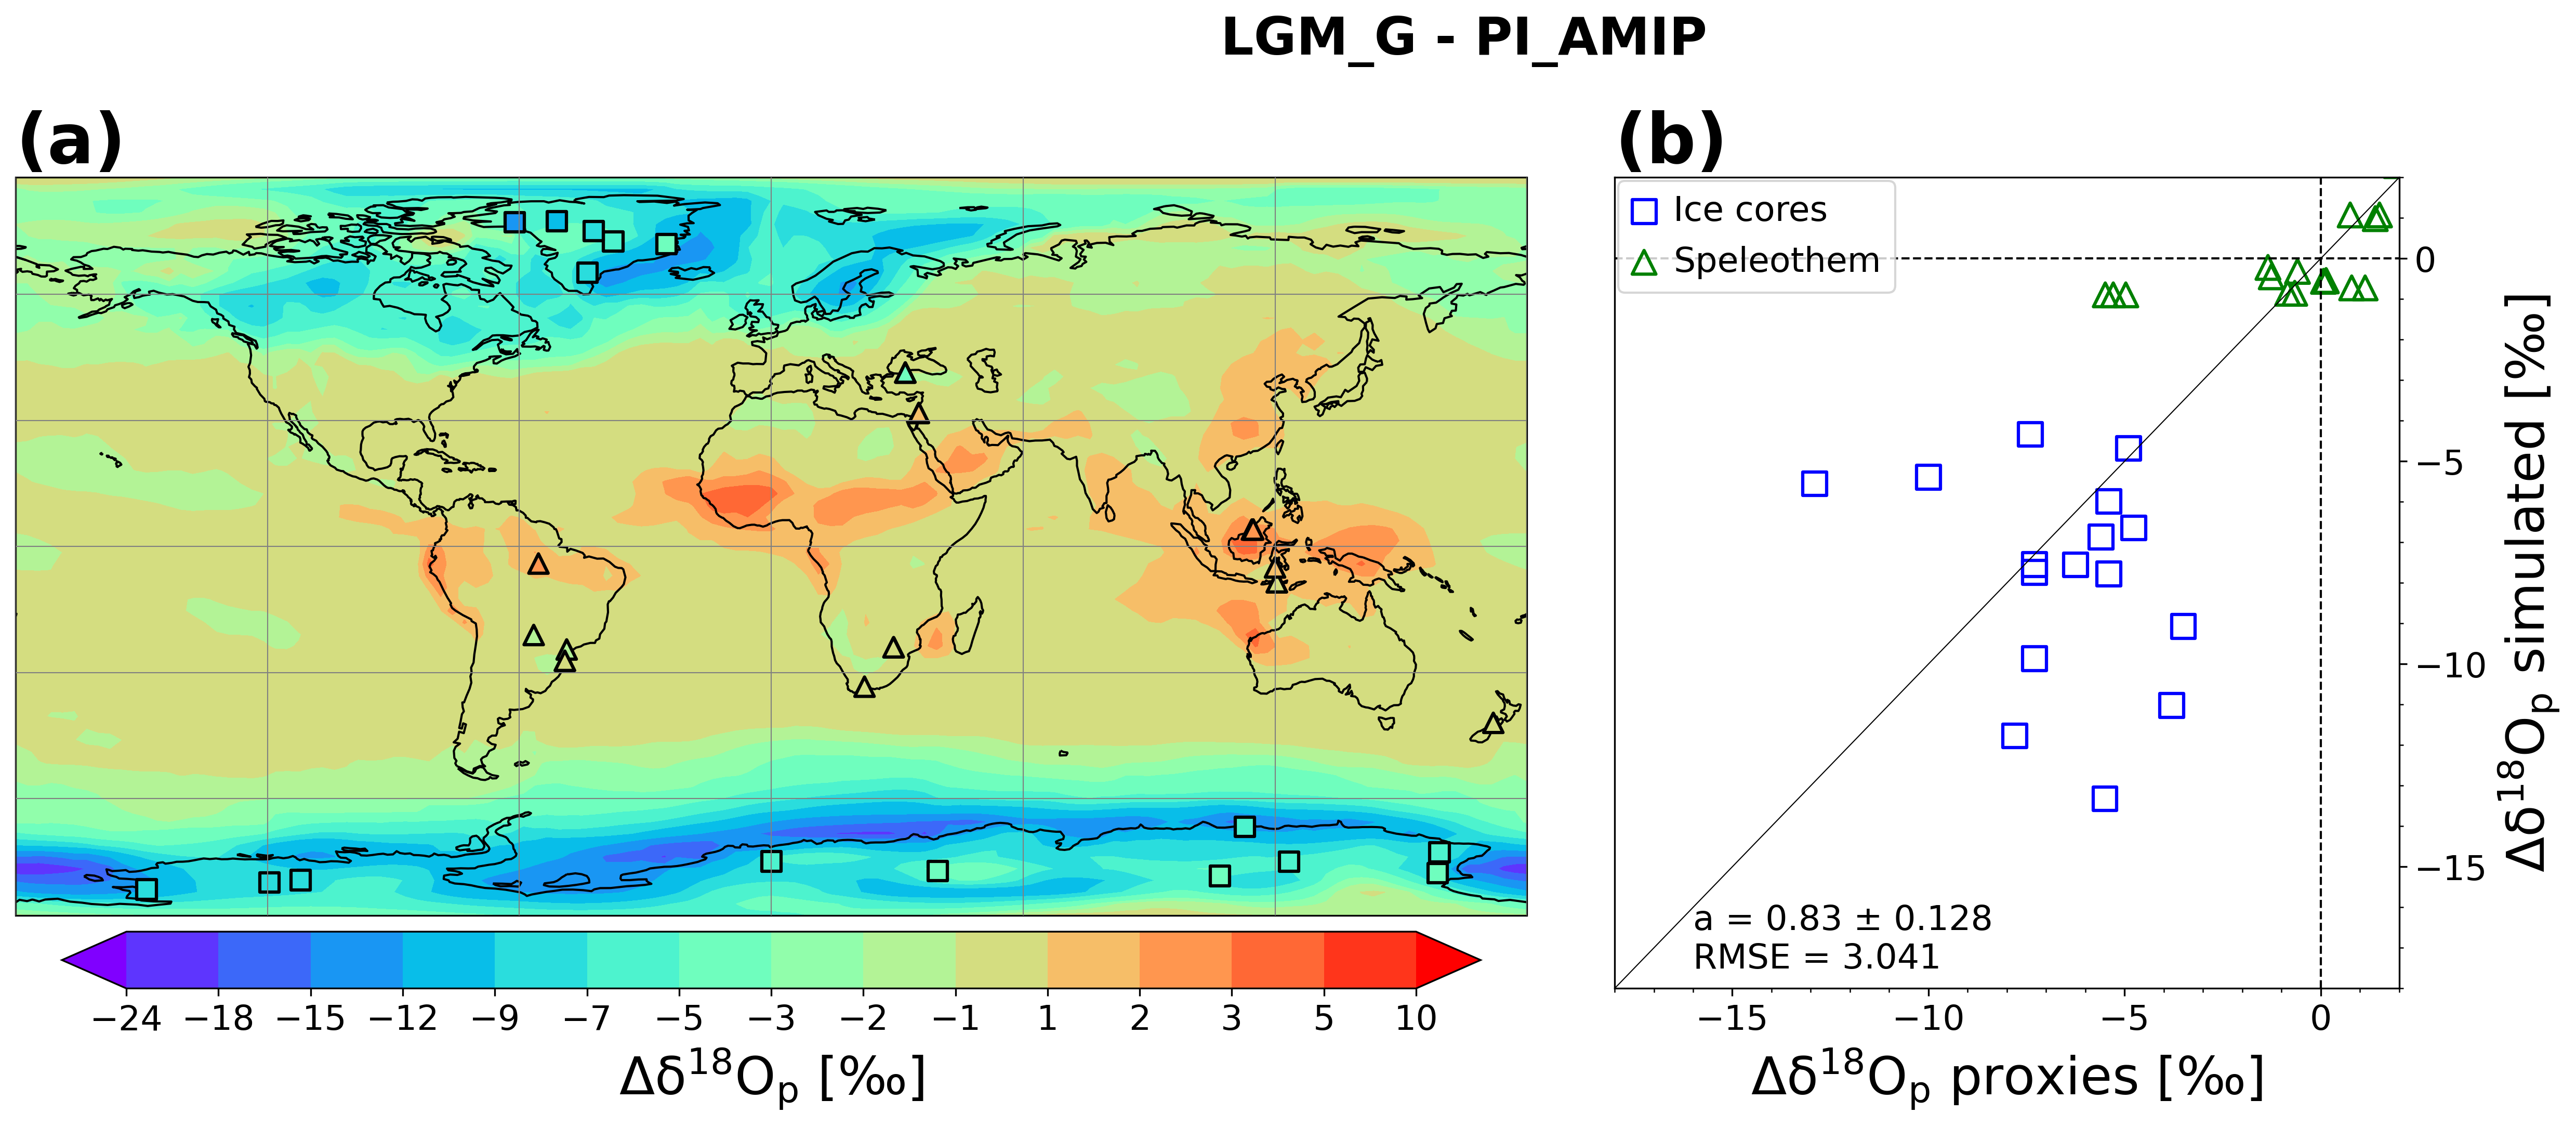

In [27]:
fig = plt.figure(figsize=(20,8))
fig.suptitle(f"{exp_label} - {exp_label_ref}",weight="demibold", fontsize=24)
# Subplot Map
ax1 = plt.subplot2grid((1,3),(0,0), projection=ccrs.PlateCarree(),colspan=2)
# plot de la map
cs = ax1.contourf(dlon, dlat, prcp_d18O_ann-prcp_d18O_ann_ref, norm=norm, cmap=cmap, levels=levels,transform=ccrs.PlateCarree(),extend="both")
ax1.coastlines()
ax1.scatter(data_ice["longitude"], data_ice["latitude"], c=data_ice["d18O"], 
            s=80, cmap=cmap, marker="s", edgecolors="k", 
            linewidth=1.5, norm=norm, zorder=3, transform=ccrs.PlateCarree())
ax1.scatter(data_speleo["longitude"], data_speleo["latitude"], c=data_speleo["d18O"], 
            s=80, cmap=cmap, marker="^", edgecolors="k", 
            linewidth=1.5, norm=norm, zorder=3, transform=ccrs.PlateCarree())
# ax1.contour(dlon,dlat , grlndf_LGM, levels=[0.5],
#                        colors=["black"], linewidths=1.5, alpha=1, transform=ccrs.PlateCarree(),zorder=100)
ax1.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=False,
                  linewidth=0.5, linestyle='-', color='gray', alpha=1, zorder=200)
# Colorbar
cbar=plt.colorbar(cs,orientation='horizontal',ticks=levels,pad=0.02, fraction=0.07, aspect=25)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(f"{prcp_d18Oa_label_s} {prcp_d18Oa_unit}", size=24)
# text
ax1.set_title("(a)", loc="left",fontsize=32,weight="demibold")


# Subplot
ax2 = plt.subplot2grid((1,3), (0, 2),colspan=1)
plt.plot([-70,10],[-70,10],"k",linewidth=0.5)
#l1 = plt.scatter(d18O_gnip,d18O_hist_scatter_gnip, s=80, facecolors="none", edgecolors="red", marker="o")
l2 = plt.scatter(data_ice["d18O"],data_ice["md18O"], s=120, facecolors="none", edgecolors="b", marker="s", linewidth=1.5)
l3 = plt.scatter(data_speleo["d18O"],data_speleo["md18O"], s=120, facecolors="none", edgecolors="green", marker="^", linewidth=1.5)

plt.xlabel(f"{prcp_d18Oa_label_s} proxies {prcp_d18Oa_unit}", fontsize=24)
plt.ylabel(f"{prcp_d18Oa_label_s} simulated {prcp_d18Oa_unit}", fontsize=24)
ax2.set_yticks(np.arange(-45,10,5))
ax2.set_yticks(np.arange(-70,15,1), minor=True)
ax2.set_xticks(np.arange(-35,10,5))
ax2.set_xticks(np.arange(-45,15,1), minor=True)
ax2.tick_params(labelsize=16) 
plt.xlim(-18,2)
plt.ylim(-18,2)

plt.legend([l2,l3], ["Ice cores","Speleothem"], loc="upper left",  ncol=1, fontsize=16, handletextpad=0.5, borderaxespad=0.1, borderpad=0.4, handlelength=0.7)

# lines
plt.axvline(x=0,ls="--",linewidth=1, color="k")
plt.axhline(y=0,ls="--",linewidth=1, color="k")

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# text
plt.text(0.1, 0.025, text_d18Op_LGM, horizontalalignment="left", verticalalignment="baseline", fontsize=16, transform=ax2.transAxes)
ax2.set_title("(b)", loc="left",fontsize=32,weight="demibold")

plt.subplots_adjust(top=0.85,bottom=0.2,left=0.02,right=0.8,hspace=0.05,wspace=0.05)
fig.show()
#fig.savefig("global_model-data_comparison.png")